## 1. 사용할 패키지 불러오기

In [42]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm 
from konlpy.tag import Okt
import itertools
from collections import Counter
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
import gensim
from gensim import models
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

In [2]:
import matplotlib.font_manager as fm
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/H2GTRE.ttf").get_name()
rc('font', family=font_name)

## 2. 데이터 불러오기

In [7]:
data = pd.read_csv('kakaoreview.csv', encoding='utf-8')
data.head()

Unnamed: 0                              reviewId     userName   
0           0  ac0fbabd-8ee3-4819-81fb-b3ffa8a296dd          김정선  \
1           1  1e723c87-9a05-49d5-aa2f-303adeaea3bf          박블리   
2           2  6d247505-e723-40cf-9fad-7cde6806082c       강대한애국당   
3           3  19be772b-c5c0-404b-939a-6bf8bd9b5578  Gangmin Kim   
4           4  2890cae1-b71f-4312-8126-423e6c5de920        치천후TV   

                                           userImage   
0  https://play-lh.googleusercontent.com/a/AGNmyx...  \
1  https://play-lh.googleusercontent.com/a/AGNmyx...   
2  https://play-lh.googleusercontent.com/a/AGNmyx...   
3  https://play-lh.googleusercontent.com/a/AGNmyx...   
4  https://play-lh.googleusercontent.com/a-/ACB-R...   

                                             content  score  thumbsUpCount   
0  카카오블루를 부르는 이유는 택시를 빨리 잡아 목적지에 빨리 도달하기 위해서인데 주변...      1              0  \
1                                            좋은어플이에요      5              0   
2  ㅌ66 ㅣ기4ㄴㄱㄴㄱ#2-+`1+-+!Qwzwzasqzaㅣㅇ비비zw1ssQㅣㅋㅋ1a...      3              0   
3  카카오는 왜 기업이 독점을 하면서 서비스가 항상 밥찌꺼기같은지 모르겠네요 왜 자꾸 ...      1              0   
4  자전거 자주이용하고잇엇는데 3일 전부터 거리에 쉽게 찾을수잇던 카카오바이크가 검색창...      1              0   

  reviewCreatedVersion          at appVersion  
0                  NaN  2023-05-03        NaN  
1                6.2.1  2023-05-03      6.2.1  
2               5.12.1  2023-05-03     5.12.1  
3                6.2.1  2023-05-03      6.2.1  
4                  NaN  2023-05-02        NaN

## 3. 데이터 전처리

### (1) 불용어 정의

In [8]:
# 불용어 리스트 생성(형용사)
stopwords = ['대한', '있다', '없다', '아니다', '같다', '']

### (2) Tokenizer 정의 (명사, 형용사)

In [9]:
okt = Okt()
def my_tokenizer(doc):
    tokens = [token for token, pos in okt.pos(doc, norm=True, stem=True) if pos in ['Noun', 'Adjective']] # 토큰화, 명사만 출력
    tokens = [word for word in tokens if (word not in stopwords) & (len(word) > 1)] # 불용어 제거, 1글자 제외
    return tokens

### (3) Token 생성

In [11]:
Token = [my_tokenizer(sentence) for sentence in tqdm(data['content'])]

100%|███████████████████████████████████████████████████████████████████████████| 52903/52903 [05:31<00:00, 159.77it/s]


### (4) 단어 빈도 수 및 전처리 결과 저장

In [22]:
def word_frequency(Token):
    flatten_tokens = list(itertools.chain(*Token))
    token_count = Counter(flatten_tokens)
    word_count = pd.DataFrame.from_dict(token_count, orient='index').reset_index()
    word_count.columns = ['Word', 'Frequency']
    word_count = word_count.sort_values(by = 'Frequency', ascending = False).reset_index(drop = True)
    return word_count

In [31]:
sentences = [" ".join(tok) for tok in Token]
data['preprocessed'] = sentences

In [23]:
word_count = word_frequency(Token)
word_count.head(20)

Word  Frequency
0     택시      21669
1     좋다      16257
2     기사      11796
3     있다       8705
4    카카오       7227
5     없다       5681
6     이용       5029
7    편하다       4662
8    아니다       4312
9     위치       3865
10    호출       3774
11    같다       3666
12    취소       3664
13   안되다       3653
14    어플       3077
15    사용       2957
16  편리하다       2863
17    진짜       2724
18    거리       2467
19    시간       2152

In [40]:
data.loc[:, ['reviewId','userName','content','preprocessed','at', 'score']].to_excel('preprocessed.xlsx', index = False)
word_count.to_csv('word_count.csv', index = False, encoding = 'euc-kr')

## 4. 토픽 분석

In [43]:
id2word=corpora.Dictionary(Token)
id2word.filter_extremes(no_below = 3) #3회 이하로 등장한 단어는 삭제
texts = Token
corpus=[id2word.doc2bow(text) for text in texts]

os.makedirs('./토픽분석', exist_ok = True)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (1) 적절한 토픽 개수 선정

In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.savefig('./토픽분석/토픽개수선정.png')
    plt.show()
    
    return model_list, coherence_values

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


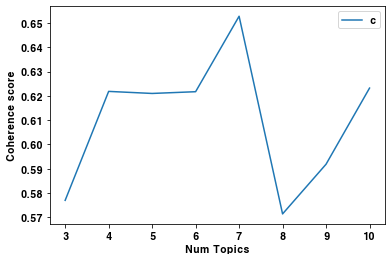

In [47]:
start_topic_num = 3
end_topic_num = 10
step = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start_topic_num, limit=end_topic_num+1, step=step)

In [48]:
best_topic_num = range(start_topic_num, end_topic_num+1, step)[coherence_values.index(max(coherence_values))]
print("Best topic number: {}".format(best_topic_num))

Best topic number: 7


c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (2) 최적의 토픽 개수에 대해서 토픽별 단어 저장

In [49]:
best_model = model_list[coherence_values.index(max(coherence_values))]
topics = best_model.print_topics(num_words=8) 
topics

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.162*"택시" + 0.064*"카카오" + 0.053*"있다" + 0.044*"기사" + 0.026*"이용" + 0.024*"호출" + 0.020*"없다" + 0.018*"같다"'),
 (1,
  '0.067*"기사" + 0.050*"위치" + 0.031*"택시" + 0.028*"있다" + 0.023*"도착" + 0.018*"요금" + 0.015*"출발" + 0.015*"지도"'),
 (2,
  '0.070*"택시" + 0.036*"기사" + 0.028*"진짜" + 0.021*"목적지" + 0.021*"아니다" + 0.019*"거리" + 0.017*"어디" + 0.016*"안심"'),
 (3,
  '0.074*"기사" + 0.069*"친절하다" + 0.038*"콜비" + 0.023*"용하다" + 0.016*"없다" + 0.015*"탑승" + 0.015*"안되다" + 0.014*"카드"'),
 (4,
  '0.047*"최고" + 0.045*"어플" + 0.035*"위치" + 0.028*"이다" + 0.027*"택시" + 0.026*"완전" + 0.025*"없다" + 0.023*"카카오"'),
 (5,
  '0.071*"택시" + 0.046*"기사" + 0.030*"취소" + 0.026*"없다" + 0.020*"전화" + 0.019*"아니다" + 0.018*"안되다" + 0.016*"번호"'),
 (6,
  '0.366*"좋다" + 0.096*"편하다" + 0.052*"편리하다" + 0.043*"이용" + 0.035*"있다" + 0.033*"정말" + 0.031*"빠르다" + 0.023*"사용"')]

In [ ]:
topic_words = dict()

for i in range(best_topic_num):
    words = [word for (word, prob) in best_model.show_topic(i, 20)]
    topic_words['Topic_' + str(i + 1)] = words
    
topic_words = pd.DataFrame(topic_words)

os.makedirs('./토픽분석', exist_ok = True)

topic_words.to_excel(os.path.join('./토픽분석', 'Topic Words.xlsx'), index = False)
topic_words.head(10)

### (3) 토픽 모델링 시각화

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, os.path.join('./토픽분석', 'Topic Plot.html'))